In [1]:
import numpy as np
from matplotlib import pyplot as plt

# Load Data

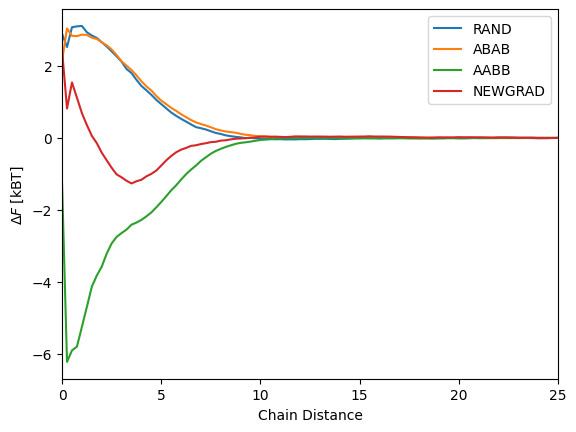

In [13]:
import numpy as np
import matplotlib.pyplot as plt
 
# Define the sequences
sequences = ['RAND', 'ABAB', 'AABB', 'NEWGRAD']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_N_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=seq)

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


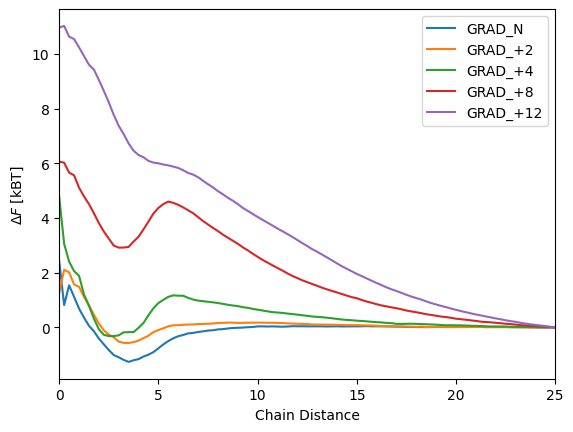

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = [ "GRAD"]

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:

    tag = f'poly_sequ_{seq}_N_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N')

    tag = f'poly_sequ_{seq}_N_+2_2_nchain_2_temp_1_pmf'

    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2')

    tag = f'poly_sequ_{seq}_N_+4_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4')

    tag = f'poly_sequ_{seq}_N_+8_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+8')

    tag = f'poly_sequ_{seq}_N_+12_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+12')

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


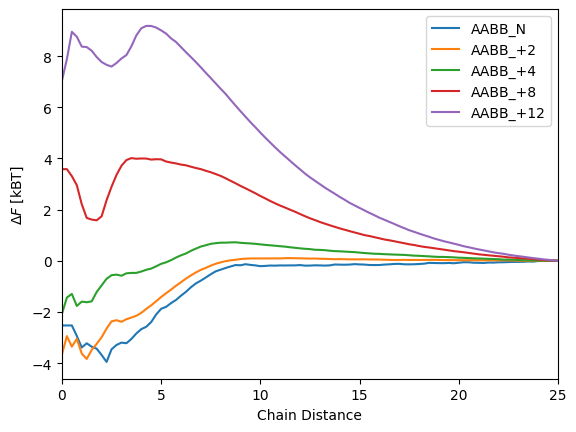

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['AABB']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    
    tag = f'poly_sequ_{seq}_N_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N')

    tag = f'poly_sequ_{seq}_N_+2_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2')

    tag = f'poly_sequ_{seq}_N_+4_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4')

    tag = f'poly_sequ_{seq}_N_+8_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+8')

    tag = f'poly_sequ_{seq}_N_+12_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+12')

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


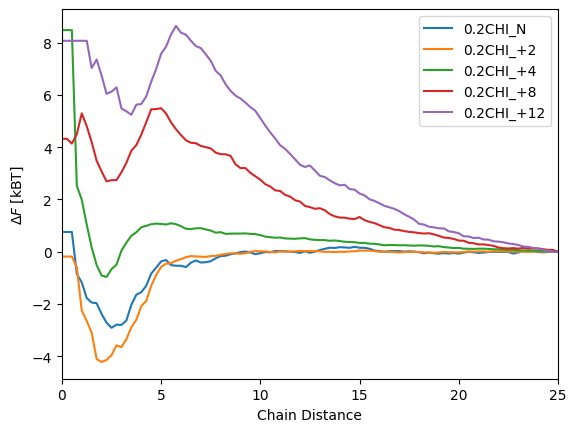

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['0.2CHI']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:

    tag = f'poly_sequ_{seq}_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N')
    
    tag = f'poly_sequ_{seq}_+2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2')

    tag = f'poly_sequ_{seq}_+4_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4')

    tag = f'poly_sequ_{seq}_+8_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+8')

    tag = f'poly_sequ_{seq}_+12_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+12')
    

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


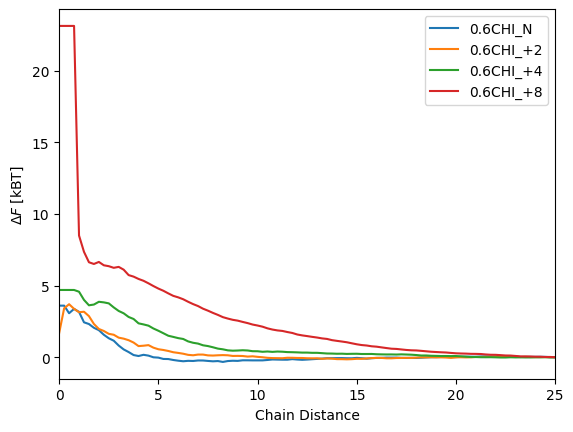

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['0.6CHI']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:

    tag = f'poly_sequ_{seq}_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N')
    
    tag = f'poly_sequ_{seq}_+2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2')

    tag = f'poly_sequ_{seq}_+4_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4')

    tag = f'poly_sequ_{seq}_+8_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+8')

    # tag = f'poly_sequ_{seq}_+12_2_nchain_2_temp_1_pmf'
    # data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    # plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+12')

    

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


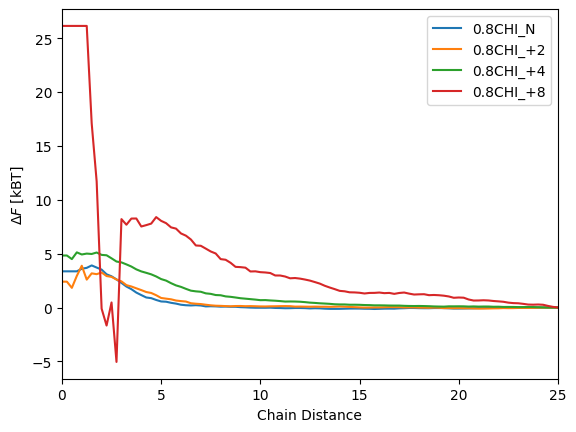

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['0.8CHI']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:

    tag = f'poly_sequ_{seq}_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N')
    
    tag = f'poly_sequ_{seq}_+2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2')

    tag = f'poly_sequ_{seq}_+4_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4')

    tag = f'poly_sequ_{seq}_+8_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+8')

    

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


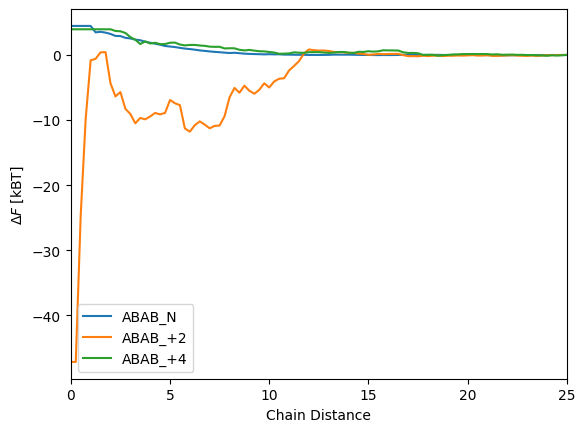

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['ABAB']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:

    tag = f'poly_sequ_{seq}_N_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N')
    
    tag = f'poly_sequ_{seq}_N_+2_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+2')

    tag = f'poly_sequ_{seq}_N_+4_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_+4')

    

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


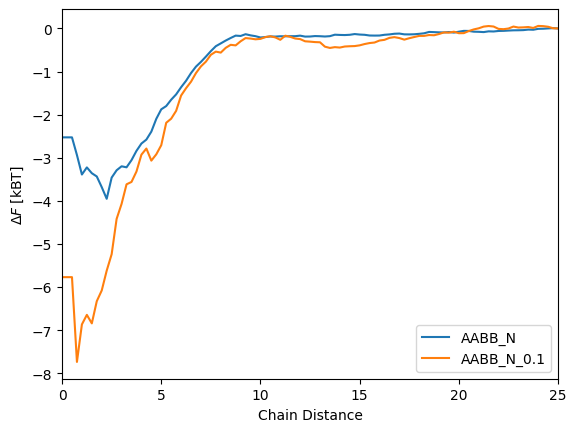

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sequences
sequences = ['AABB']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:

    tag = f'poly_sequ_{seq}_N_2_nchain_2_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N')

    tag = f'poly_sequ_{seq}_N_2_nchain_2_nsalt_4_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N_0.1')

    tag = f'poly_sequ_{seq}_N_2_0.5_nchain_2_nsalt_20_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N_0.5')

    tag = f'poly_sequ_{seq}_N_2_1.0_nchain_2_nsalt_40_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N_1.0')

    tag = f'poly_sequ_{seq}_N_2_2.0_nchain_2_nsalt_80_temp_1_pmf'
    data = np.loadtxt(f'../data/{tag}/prod.pmf', skiprows=3)
    plt.plot(data[:,0], data[:,1] - data[-1,1], label=f'{seq}_N_2.0')
    

# Add labels and legend
plt.xlabel('Chain Distance')
plt.ylabel(r'$\Delta F$ [kBT]')
plt.legend()
plt.xlim(0,25)

# Show the plot
plt.show()


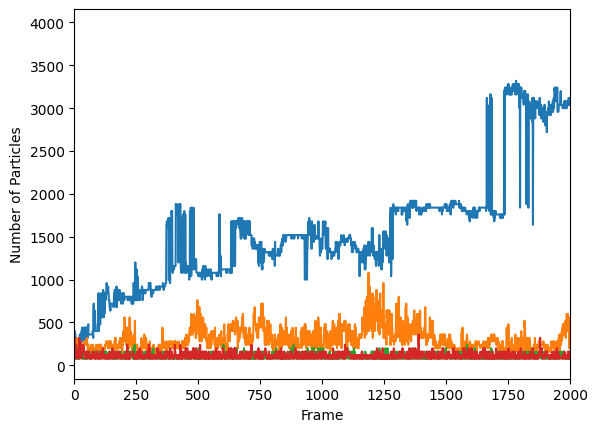

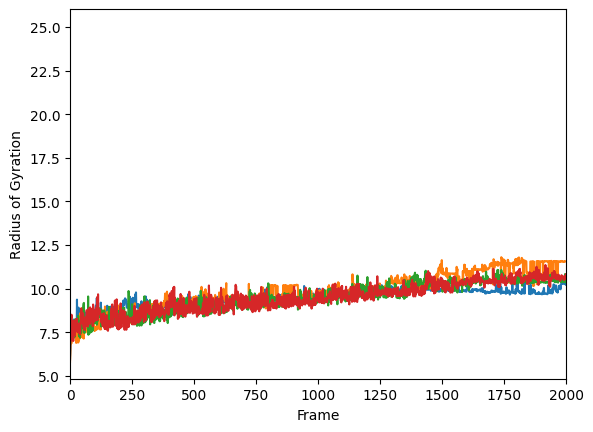

In [3]:

# Define the sequences
sequences = ['AABB','GRAD', 'ABAB','RAND']

# Initialize the plot
plt.clf()

# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_N_nchain_100_temp_1'
    data = np.loadtxt(f'../data/{tag}/cluster_size.txt', skiprows=1, usecols=[1,2])
    plt.plot(data[:,0], label=f'{seq}_cluster')

# Plot the data
plt.xlabel('Frame')
plt.ylabel('Number of Particles')
plt.xlim(0,2000)
plt.show()


# Plot data for each sequence
for seq in sequences:
    tag = f'poly_sequ_{seq}_N_nchain_100_temp_1'
    data = np.loadtxt(f'../data/{tag}/cluster_size.txt', skiprows=1, usecols=[1,2])
    plt.plot(np.sqrt(data[:,1]), label=f'{seq}_cluster')

# Plot the data
plt.xlabel('Frame')
plt.ylabel('Radius of Gyration')
plt.xlim(0,2000)
plt.show()

# Radius of Gyration

In [269]:
gyr = Gyradius(ag,n_chains=100,n_monomers=40, unwrap=True)

In [270]:
gyr.run(start=1000)

100%|██████████| 2001/2001 [00:00<00:00, 6312.60it/s]


In [271]:
np.savetxt('../data/'+tag+'/gyr.txt',gyr.results.gyradii)

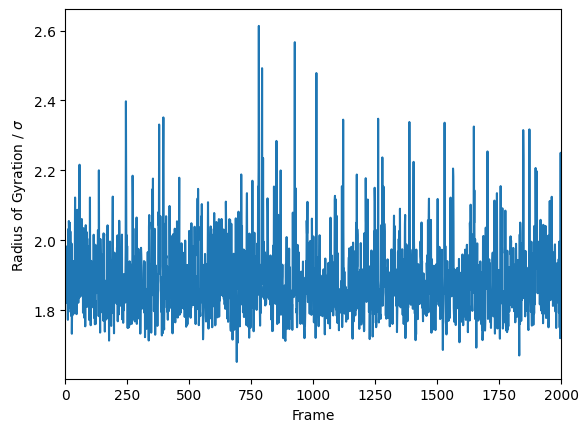

In [272]:
plt.plot(gyr.results.gyradii[0])
plt.xlabel('Frame')
plt.ylabel(f'Radius of Gyration / $\sigma$')
plt.xlim(0,2000)
plt.savefig('../data/'+tag+'/gyr.pdf')

# End-to-end Vector

In [273]:
e2e = EndToEndVector(ag,n_chains=1,n_monomers=40, unwrap=True)

/home/kfu/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py:725: UserWarning: Reader has no dt information, set to 1.0 ps
  return self.ts.dt


In [274]:
e2e.run(start=1000)
e2e.save('../data/'+tag+'/e2e')

/home/kfu/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/LAMMPS.py:598: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data['time'] = step_num * ts.dt
100%|██████████| 2001/2001 [00:00<00:00, 8074.74it/s]
1it [00:00, 2693.84it/s]


In [275]:
abs_e2e = np.zeros(len(e2e._e2e))

for i in range(len(e2e._e2e)):
    abs_e2e[i] = np.linalg.norm(e2e._e2e[i])

abs_e2e

array([2.23543372, 1.07988825, 1.16543384, ..., 3.27568639, 4.67249535,
       2.97711096])

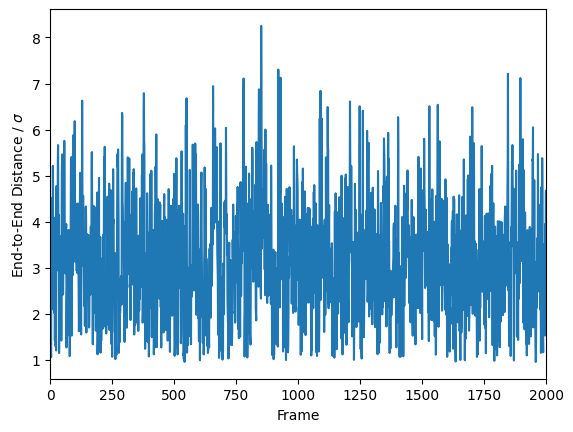

In [276]:
plt.plot(e2e.results.times,abs_e2e)
plt.xlabel('Frame')
plt.ylabel('End-to-End Distance / $\sigma$')
plt.xlim(0,2000)
plt.savefig('../data/'+tag+'/e2e.pdf')

/tmp/ipykernel_3005737/900919511.py:4: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,3000)


(0.6838305520458344, 3000)

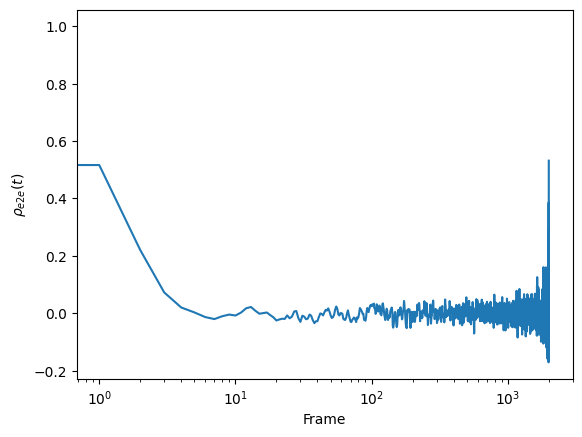

In [277]:
plt.semilogx(e2e.results.times,e2e.results.acf[0][0])
plt.xlabel('Frame')
plt.ylabel(r'$ \rho_{e2e}(t)$')   
plt.xlim(0,3000)